In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime, timedelta

from PYSCRP.myplot import get_xy_lim
sns.set_theme('paper')
%matplotlib inline

# Get data
## Define functions

In [2]:
with open('dolthub.key', 'r') as f:
    key = f.readline().strip()

# https://www.dolthub.com/repositories/post-no-preference/stocks
def get_data(query, repo, key, owner="post-no-preference", branch="master", timeout=40):
    res = requests.get(
        f"https://www.dolthub.com/api/v1alpha1/{owner}/{repo}/{branch}",
        params={"q": query},
        headers={"authorization": f"token {key}" },
        timeout=timeout,
    )
    try:
        res = res.json()
        return pd.DataFrame(res['rows'])
    except Exception as e:
        return e, res
    
    
def get_query_income(stock, date_start):
    """Return query for getting inconme statement 
    Note:
        repo = earning
    """
    
    return f"""
    -- Data and TTM data from income statement
    with cte as (
    SELECT act_symbol, `date`, period, sales, gross_profit, income_after_depreciation_and_amortization, net_income, average_shares, diluted_eps_before_non_recurring_items, diluted_net_eps,
        sum(sales) over (order by `date` rows between 3 preceding and current row) as sales_TTM,
        sum(gross_profit) over (order by `date` rows between 3 preceding and current row) as gross_profit_TTM,
        sum(income_after_depreciation_and_amortization) over (order by `date` rows between 3 preceding and current row) as income_after_depreciation_and_amortization_TTM,
        sum(net_income) over (order by `date` rows between 3 preceding and current row) as net_income_TTM,
        sum(diluted_eps_before_non_recurring_items) over (order by `date` rows between 3 preceding and current row) as diluted_eps_before_non_recurring_items_TTM,
        sum(diluted_net_eps) over (order by `date` rows between 3 preceding and current row) as diluted_net_eps_TTM
    FROM `income_statement`
    where 
        act_symbol = '{stock}'
        and `date` > '{date_start}'
        and period = 'Quarter'
    union all
    SELECT act_symbol, `date`, period, sales, gross_profit, income_after_depreciation_and_amortization, net_income, average_shares, diluted_eps_before_non_recurring_items, diluted_net_eps, 
        null as sales_TTM, null as gross_profit_TTM, null as income_after_depreciation_and_amortization_TTM, null as net_income_TTM, 
        null as diluted_eps_before_non_recurring_items_TTM, null as diluted_net_eps_TTM
    FROM `income_statement`
    where 
        act_symbol = '{stock}'
        and `date` > '{date_start}'
        and period = 'Year'
    ),
    -- Divide all by 1 million except per share data
    div_by_million AS (
        select 
            act_symbol, `date`, period, 
            average_shares / 1000000 AS average_shares,
            
            sales / 1000000 AS sales,
            gross_profit / 1000000 AS gross_profit,
            income_after_depreciation_and_amortization / 1000000 AS income_after_depreciation_and_amortization,
            net_income / 1000000 AS net_income,

            diluted_eps_before_non_recurring_items,
            diluted_net_eps,
            
            sales_TTM / 1000000 AS sales_TTM,
            gross_profit_TTM / 1000000 AS gross_profit_TTM,
            income_after_depreciation_and_amortization_TTM / 1000000 AS income_after_depreciation_and_amortization_TTM,
            net_income_TTM / 1000000 AS net_income_TTM,

            diluted_eps_before_non_recurring_items_TTM,
            diluted_net_eps_TTM
        from cte
    ),
    -- Income data and margins
    income AS (
        select *,
            gross_profit / sales as margin_gross,
            income_after_depreciation_and_amortization / sales as margin_opr,
            net_income / sales as margin_net,
            gross_profit_TTM / sales_TTM as margin_gross_TTM,
            income_after_depreciation_and_amortization_TTM / sales_TTM as margin_opr_TTM,
            net_income_TTM / sales_TTM as margin_net_TTM
        from div_by_million
    ),
    assets AS (
    SELECT act_symbol, `date`, period, total_assets / 1000000 AS total_assets
    FROM balance_sheet_assets 
    WHere
        act_symbol = '{stock}'
        and `date` > '{date_start}'
    ),
    equity AS (
    SELECT act_symbol, `date`, period, 
        total_equity / 1000000 AS total_equity,
        shares_outstanding / 1000000 AS shares_outstanding, 
        book_value_per_share
    FROM balance_sheet_equity
    WHere
        act_symbol = '{stock}'
        and `date` > '{date_start}'
    ),
    liabilities AS (
    SELECT act_symbol, `date`, period, total_liabilities / 1000000 AS total_liabilities
    FROM balance_sheet_liabilities
    WHere
        act_symbol = '{stock}'
        and `date` > '{date_start}'
    ),
    cash AS (
    SELECT act_symbol, `date`, period, 
        net_cash_from_operating_activities / 1000000 AS net_cash_from_operating_activities, 
        net_change_in_cash_and_equivalents / 1000000 AS net_change_in_cash_and_equivalents
    FROM cash_flow_statement 
    WHere
        act_symbol = '{stock}'
        and `date` > '{date_start}'
    )
    select i.*,
        a.total_assets,
        e.total_equity, e.shares_outstanding, e.book_value_per_share,
        l.total_liabilities,
        c.net_cash_from_operating_activities, c.net_change_in_cash_and_equivalents
    from income i
    left join assets a
        on i.act_symbol = a.act_symbol
        and i.`date` = a.`date`
        and i.period = a.period
    LEFT join equity e 
        on i.act_symbol = e.act_symbol
        and i.`date` = e.`date`
        and i.period = e.period
    LEFT join liabilities l
        on i.act_symbol = l.act_symbol
        and i.`date` = l.`date`
        and i.period = l.period
    LEFT join cash c
        on i.act_symbol = c.act_symbol
        and i.`date` = c.`date`
        and i.period = c.period
    """


def get_query_price(stock, dates):
    """Return query for getting price corresponding to the date of ER
    Note:
        dates: dates of ER retrieved from income statement data
    """
    # Append yesterday's price
    yesterday = date.today() - timedelta(days=1)
    dates.append(yesterday.strftime("%Y-%m-%d"))
    week_dates = []
    for i in dates:
        i_date = datetime.strptime(i, "%Y-%m-%d").date()
        weekday = i_date.weekday()
        # Use the previou Friday if the date falls on a weekend
        if weekday == 5:  # Sat
            latest_weekday = i_date - timedelta(days=1)
        elif weekday == 6:  # Sun
            latest_weekday = i_date - timedelta(days=2)
        else:
            latest_weekday = i_date
        week_dates.append(latest_weekday.strftime("%Y-%m-%d"))

    # Query for getting the price
    dates_string = "'" + "', '".join(week_dates) + "'"
    return ("WITH d AS (\n" + 
        "\nUNION ALL\n".join([f"SELECT CAST('{date}' AS DATE) AS date" for date in week_dates]) + 
        ")\n" + 
        f"""SELECT p.act_symbol, p.close, p.volume, d.date AS price_actual_date
        FROM d
        LEFT JOIN (
            SELECT act_symbol, `date`, `close`, volume
            FROM ohlcv
            WHere
                act_symbol = '{stock}'
                and `date` IN ({dates_string})
        ) p
        ON d.`date` = p.`date`"""
        )


## Get ER data

In [18]:
stock = 'MSFT'
repo = "earnings"
date_start = '2017-12-31'
df0 = get_data(get_query_income(stock, date_start), repo, key)
# Because of the TTM sum, the first 3 TTM are meaningless. Thus just remove data of the first year
df = df0[df0['date'] > datetime.strftime((datetime.strptime(date_start, '%Y-%m-%d') + timedelta(days=366)), '%Y-%m-%d')].copy()
# string to float
df[df.columns.drop(['act_symbol', 'date', 'period'])] = df[df.columns.drop(['act_symbol', 'date', 'period'])].astype(float)

## Get price data (optional)

Get price on the date correspondng to the end of earning quarter. Caveats are
- The date may be a weekend. So get the previous Friday if so
- There are missing data in the online table. So I need to manually fill them up after downloading
- Since earnings are usually reported several weeks after the quarter end date, on the quarter end date investors are not aware of it. The price on quarter end date thus does not account for people's reaction to the earnings 

In [19]:
er_dates = df[df['period'] == 'Quarter']['date'].unique().tolist() 
repo = "stocks"

# It may time out with API. If so, run on the website first and try again
# https://www.dolthub.com/repositories/post-no-preference/stocks/query/master
# If still not working, run on the website and save to csv
df_price0 = get_data(get_query_price(stock, er_dates), repo, key)

df_price = df_price0.copy()
df_price['date'] = er_dates  # er dates is modified in get_query_price()

df_price[df_price.columns.drop(['act_symbol', 'date', 'price_actual_date'])] = df_price[df_price.columns.drop(['act_symbol', 'date', 'price_actual_date'])].astype(float)

In [20]:
# NEED to fill in missing price manually
missing_rows = df_price[df_price['close'].isnull()]['price_actual_date']
print(missing_rows)
df_price['act_symbol'] = df_price['act_symbol'].fillna(stock)

17    2023-06-30
20    2024-03-29
Name: price_actual_date, dtype: object


In [21]:
fill_price_by_stock = {
    "MPW": [9.26, 4.7],
    "META": [347.71, 222.36, 286.98, 485.58],
    "MNSO": [16.99, 20.5],
    "PYPL": [66.73, 66.99, 78],
    "SNOW": [114.86],
    "BABA": [83.35, 72.36],
    "ROST": [],
    "MSFT": [340.54, 420.72],
}
fill_price = fill_price_by_stock[stock]
df_price['close'] = df_price['close'].fillna({k: v for k, v in zip(missing_rows.index, fill_price)})
df_price

,act_symbol,close,volume,price_actual_date,date
0,MSFT,117.94,25592443.0,2019-03-29,2019-03-31
1,MSFT,133.96,30042969.0,2019-06-28,2019-06-30
2,MSFT,139.03,18430390.0,2019-09-30,2019-09-30
3,MSFT,157.70,18393383.0,2019-12-31,2019-12-31
4,MSFT,157.71,77927186.0,2020-03-31,2020-03-31
5,MSFT,203.51,34310283.0,2020-06-30,2020-06-30
6,MSFT,210.33,33829088.0,2020-09-30,2020-09-30
7,MSFT,222.42,20942132.0,2020-12-31,2020-12-31
8,MSFT,235.77,43623471.0,2021-03-31,2021-03-31
9,MSFT,270.90,21656457.0,2021-06-30,2021-06-30


## Get PE and PB data (optional)

In [22]:
# Use only quarterly data
df2 = pd.merge(df_price, df[df['period'] == 'Quarter'], on=['act_symbol', 'date'], how='left')

# Fill yesterday's data with the latest ER result
df2.loc[df2.index[-2:]] = df2.loc[df2.index[-2:]].ffill()
df2['PE'] = df2['close'] / df2['diluted_net_eps_TTM']
df2['PB'] = df2['close'] / df2['book_value_per_share']

# Plot 

In [23]:
is_post_covid = True

if 'date' in df2:
    # df2['date'] = pd.to_datetime(df2['date']).dt.date
    df2 = df2.set_index('date')

date_start_plot = '2021-12-31'  # '2020-12-31'  if is_post_covid else date_start    
df2 = df2.loc[df2.index > date_start_plot, :]

df2 = df2.rename({'income_after_depreciation_and_amortization': 'operating_income',
                  'diluted_eps_before_non_recurring_items': 'eps_non_gaap',
                  'diluted_net_eps': 'eps_gaap',
                  'income_after_depreciation_and_amortization_TTM': 'operating_income_TTM',
                  'diluted_eps_before_non_recurring_items_TTM': 'eps_non_gaap_TTM',
                  'diluted_net_eps_TTM': 'eps_gaap_TTM',
                  }, axis=1)

## Plot income and margin

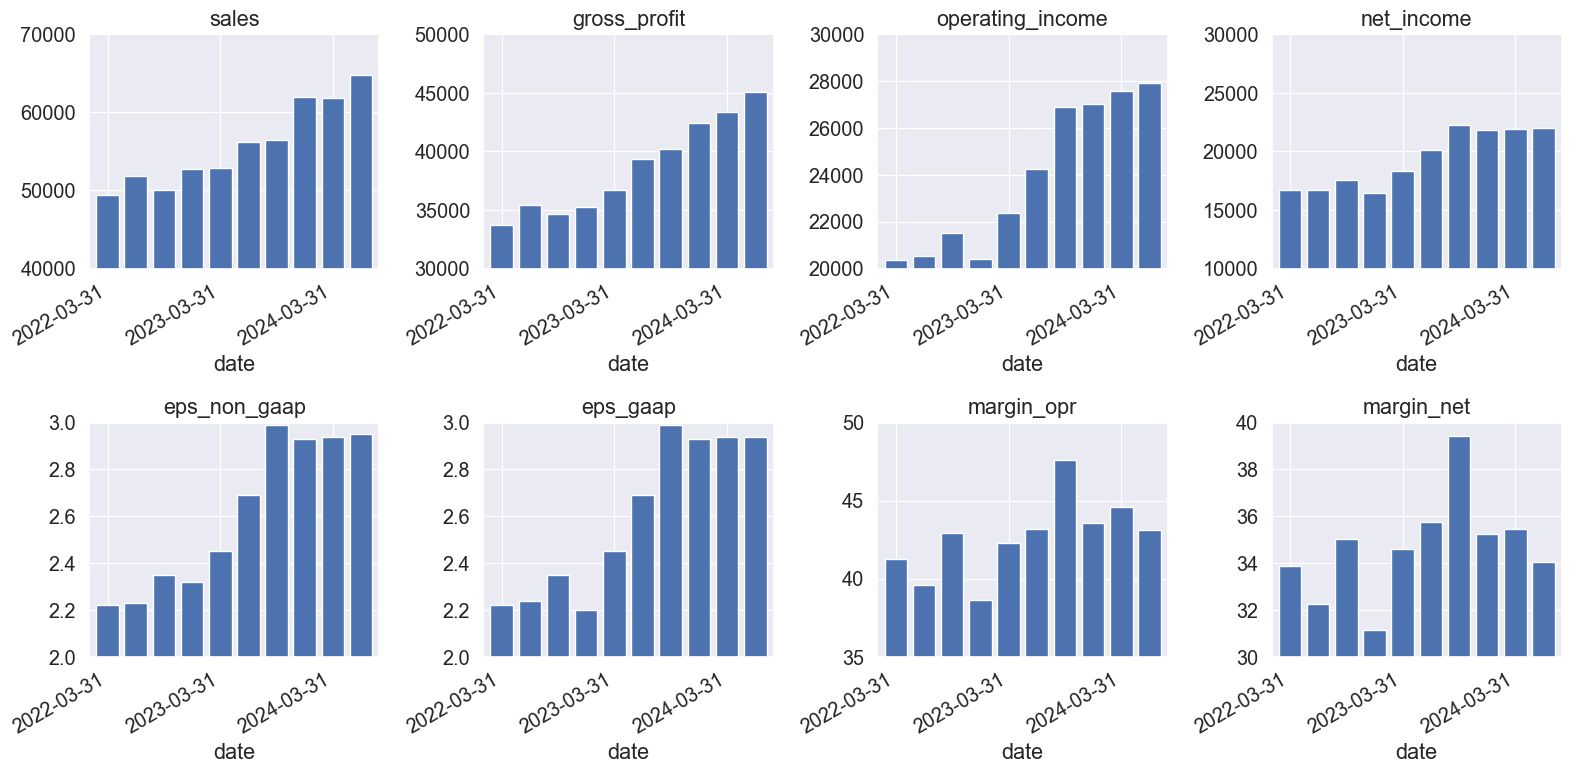

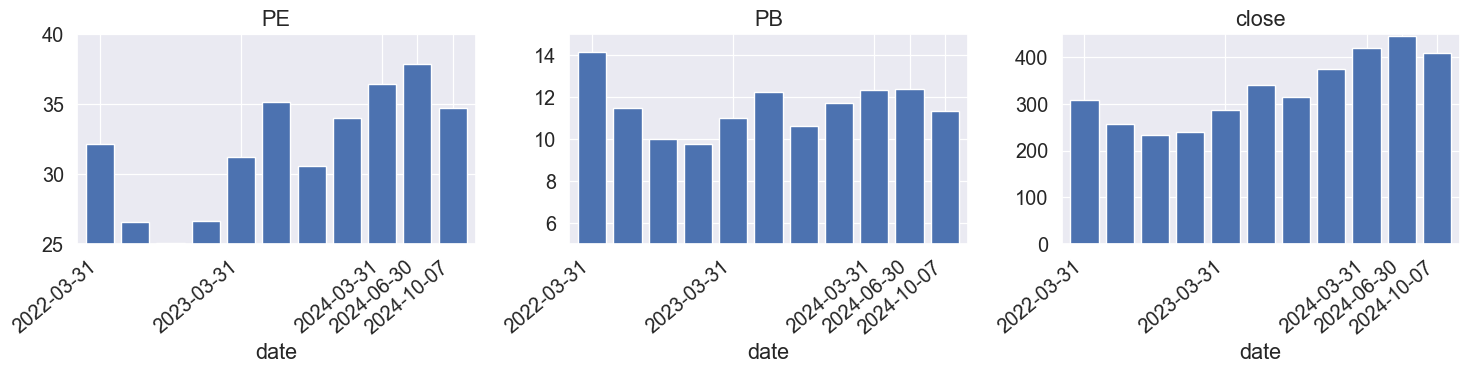

In [24]:
sns.set_theme(font_scale=1.3)

# Revenue, Income and Margin
# The last row is for yesterday's PE
df_income = df2.iloc[:-1, :].copy()
# Change margin to percentage
df_income[['margin_gross', 'margin_opr', 'margin_net', 'margin_gross_TTM', 'margin_opr_TTM', 'margin_net_TTM']] =\
    df_income[['margin_gross', 'margin_opr', 'margin_net', 'margin_gross_TTM', 'margin_opr_TTM', 'margin_net_TTM']] * 100
x_ticks = range(0, len(df_income), 4)
x_labels = df_income.index.values[x_ticks]
fig = plt.figure(figsize=(16, 8))
cols_plot = ['sales', 'gross_profit', 'operating_income', 'net_income',
             'eps_non_gaap', 'eps_gaap', 'margin_opr', 'margin_net',]
for i in range(1, 9):
    ax = fig.add_subplot(2, 4, i)
    col = cols_plot[i - 1]
    df_income[col].plot(kind='bar', ax=ax, title=col, width=0.8)
    unit = None if i <= 6 else 5
    min_y, max_y = get_xy_lim(df_income[col].values, unit)
    ax.set_ylim(min_y, max_y)
    ax.grid('both', linestyle='-', linewidth=0.9)
    ax.set_xticks(x_ticks); ax.set_xticklabels(x_labels, rotation=30, ha='right')
plt.subplots_adjust(hspace=0.6)
fig.tight_layout()

# PE and PB
df_pepb = df2[['PE', 'PB', 'close']].copy()
x_ticks = list(set(list(range(0, len(df_pepb), 4)) + [len(df_pepb) - 2, len(df_pepb) - 1]))
x_labels = df_pepb.index.values[x_ticks]

fig = plt.figure(figsize=(15, 4))
cols_plot = ['PE', 'PB', 'close']
for i in range(1, 4):
    ax = fig.add_subplot(1, 3, i)
    col = cols_plot[i - 1]
    df_pepb[col].plot(kind='bar', ax=ax, title=col, width=0.8)
    unit = 5
    min_y, max_y = get_xy_lim(df_pepb[col].values, unit)
    if i == 3:  # for price
        min_y = 0
    ax.set_ylim(min_y, max_y)
    ax.grid('both', linestyle='-', linewidth=0.9)
    ax.set_xticks(x_ticks); ax.set_xticklabels(x_labels, rotation=40, ha='right')
plt.subplots_adjust(hspace=0.6)
fig.tight_layout()